# Overview

In this project, I will use Neural Network Matrix Factorization with Keras to predict the ratings for the books in [Book-Crossing Datasets](http://www2.informatik.uni-freiburg.de/~cziegler/BX/).


## Neural Collaborative Filtering (NCF)
This notebook will present a general framework named NCF, short for Neural network-based Collaborative Filtering. NCF is generic and can express and generalize matrix factorization under its framework. To supercharge NCF modelling with non-linearities, I will leverage a multi-layer perceptron to learn the user-item interaction function. Extensive experiments on real-world datasets show significant improvements of our proposed NCF framework over the state-of-the-art methods. Empirical evidence shows that using deeper layers of neural networks offers better recommendation performance.


## Project Content
1. Load data
2. Data Analysis and Visualization
 - investigate users data
 - investigate books data
 - investigate ratings data
 - unify dataset (users,books,ratings)
3. Train KNN model for item-based collaborative filtering
4. Use this trained model to make book recommendations to myself
5. Deep dive into the bottleneck of item-based collaborative filtering.
 - cold start problem
 - data sparsity problem
 - popular bias (how to recommend products from the tail of product distribution)
 - scalability bottleneck
6. Further study

In [1]:
import os
import time
import warnings
import pickle

# data science imports
import math
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore') # Turn off warnings
%matplotlib inline

## 1. Load Data

In [2]:
# The dataset is comprised of three separate tables: BX-Users, BX-Books, and BX-Book-Ratings.
# Each is separated by semi-colons, and the first row contains the column headers.
users = pd.read_csv('data/BX-Users.csv', sep=';', error_bad_lines=False, warn_bad_lines=False, encoding="latin-1")
books = pd.read_csv('data/BX-Books.csv', sep=';', error_bad_lines=False, warn_bad_lines=False, encoding="latin-1")
book_ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, warn_bad_lines=False, encoding="latin-1")

**Note:** The 'BX-Books' csv had multiple cases of semi-colons in the book titles which were manually cleaned to ensure proper dataframe importing. Mostly were changed to colons or commas. Also, the symbol '&amp;' appeared a lot (presumably an ampersand character), which was changed to just '&amp'.

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
User-ID     278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN                   271360 non-null object
Book-Title             271360 non-null object
Book-Author            271359 non-null object
Year-Of-Publication    271360 non-null object
Publisher              271358 non-null object
Image-URL-S            271360 non-null object
Image-URL-M            271360 non-null object
Image-URL-L            271357 non-null object
dtypes: object(8)
memory usage: 16.6+ MB


In [5]:
book_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [6]:
# checking the number of records for users, books and rating
print(f'Users: {len(users)}\nBooks: {len(books)}\nRatings: {len(book_ratings)}')

Users: 278858
Books: 271360
Ratings: 1149780


## 2. Data Analysis and Visualization

#### 1. Investigate Users Data

I will first tidy up the column names. (replacing '-' caracter with '_')

In [7]:
# replacing '-' caracter with '_'
users.columns = users.columns.str.strip().str.lower().str.replace('-', '_')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
user_id     278858 non-null int64
location    278858 non-null object
age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [8]:
# checking the number of unique user_id, comparing with total number of records of user_id 
uniq_users = users.user_id.nunique()
all_users = users.user_id.count()
print(f'No. of unique user_id entries: {uniq_users} | Total user_id entries: {all_users}')

No. of unique user_id entries: 278858 | Total user_id entries: 278858


In [9]:
# checking the data types of users
users.dtypes

user_id       int64
location     object
age         float64
dtype: object

**Note:**
The 'User-ID' field is of type 'integer', 'Location' of 'strings', and the 'Age' values are 'floats'.

Therefore, ages can probably be changed to ints. Let's take a look at the values first.

In [10]:
print(sorted(users.age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

The age range goes from 0 to 244 years old! Obviously this cannot be correct; I'll set all ages less than 5 and older than 100 to NaN to try keep them realistic.

In [11]:
users.loc[(users.age<5) | (users.age>100), 'age'] = np.nan
print(sorted(users.age.unique()))

[nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


Now the ages go from 5 to 100, with missing values entered as NaN. Let's plot this to see how they are distributed.

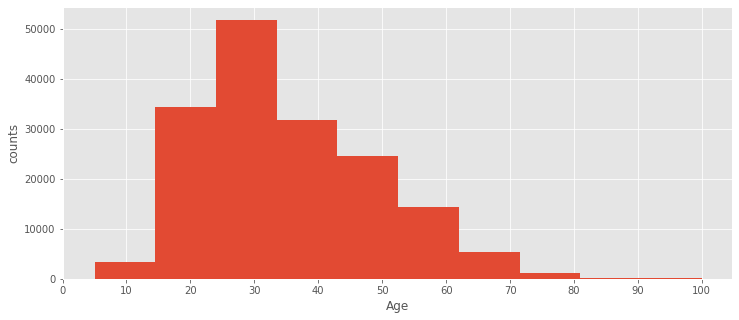

In [12]:
# First create a histogram of the Age field
ax = users.age.hist(bins=10, figsize=(12,5))
ax.set_xlabel('Age')
ax.set_ylabel('counts')
ax.set_xticks(range(0,110,10))
plt.show()

Below is the same plot without any binning - i.e. each age is represented individually.

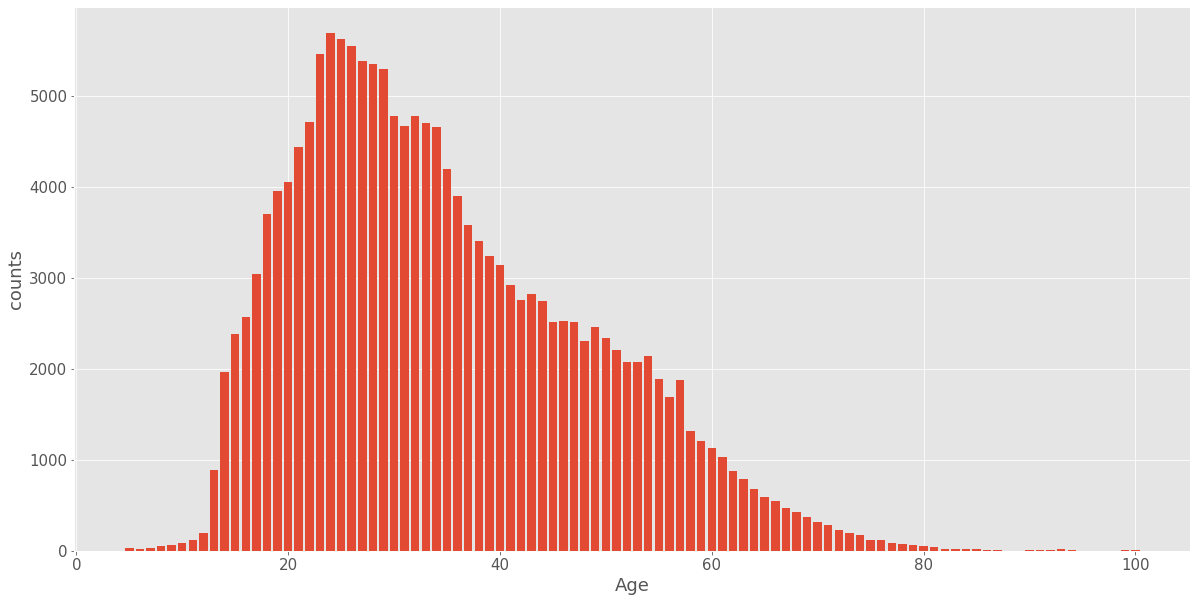

In [13]:
u = users.age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

That is more clear to me! It seems that most of our reviewers are in their late 20s to early 30s.

How many missing Age's do we now have in the dataset?

In [14]:
age_null = users.age.isnull().sum() # Sums up the 1's returned by the isnull() mask
all_users = users.user_id.count() # Counts the number of cells in the series - excludes NaNs!
print(f'There are {age_null} empty age values in our set of {all_users} users (i.e. {(age_null/all_users)*100:.2f}%).')

There are 112010 empty age values in our set of 278858 users (i.e. 40.17%).


Next, can we expand the 'Location' field to break it up into 'City', 'State', and 'Country'.

In [15]:
# Note: Used Pandas Series.str.split method as it has an 'expand' parameter which can handle None cases
user_location_expanded = users.location.str.split(',', 2, expand=True)
user_location_expanded.columns = ['city', 'state', 'country']
users = users.join(user_location_expanded)

In [16]:
users.drop(columns=['location'], inplace=True)
users.head()

,user_id,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


Let's take a quick look at these Location-derived fields.

In [17]:
top_cities = users.city.value_counts()[:10]
print(f'The 10 cities with the most users are:\n{top_cities}')

The 10 cities with the most users are:
london       4105
barcelona    2664
toronto      2342
madrid       1933
sydney       1884
portland     1869
melbourne    1863
vancouver    1699
chicago      1566
seattle      1541
Name: city, dtype: int64


In [18]:
top_countries = users.country.value_counts()[:10]
print(f'The 10 countries with the most users are:\n{top_countries}')

The 10 countries with the most users are:
 usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: country, dtype: int64


I can see that an empty 'Country' field is in the top 10 most common entries!

In [19]:
empty_string_country = users[users.country == ''].country.count()
nan_country = users.country.isnull().sum()
print(f'There are {empty_string_country} entries with empty strings, and {nan_country} NaN entries in the Country field')

There are 4561 entries with empty strings, and 2 NaN entries in the Country field


Now, I should probably change these empty strings to NaNs.

In [20]:
users.country.replace('', np.nan, inplace=True)

#### 2. Investigate Books Data

I will first tidy up the column names (replacing '-' caracter with '_'). And drop the image-url link columns.

In [21]:
# replacing '-' caracter with '_'
books.columns = books.columns.str.strip().str.lower().str.replace('-', '_') # clean column names
books.drop(columns=['image_url_s', 'image_url_m', 'image_url_l'], inplace=True) # drop image-url columns
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
isbn                   271360 non-null object
book_title             271360 non-null object
book_author            271359 non-null object
year_of_publication    271360 non-null object
publisher              271358 non-null object
dtypes: object(5)
memory usage: 10.4+ MB


What about the 'type' of each field? We probably want Year of Publication to be ints or floats, and the rest to be strings ('object'). Note: The ISBN numbers may contain some letters, so we CAN'T convert them to numeric values. Will leave as strings.

In [22]:
books.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
dtype: object

In [23]:
# Convert years to float
books.year_of_publication = pd.to_numeric(books.year_of_publication, errors='coerce')

In [24]:
# Check for 0's or NaNs in Year of Publication
zero_yr = books[books.year_of_publication == 0].year_of_publication.count()
nan_yr = books.year_of_publication.isnull().sum()
print(f'There are {zero_yr} entries as \'0\', and {nan_yr} NaN entries in the Year of Publication field')

There are 4618 entries as '0', and 3 NaN entries in the Year of Publication field


In [25]:
# Replace all years of zero with NaN
books.year_of_publication.replace(0, np.nan, inplace=True)

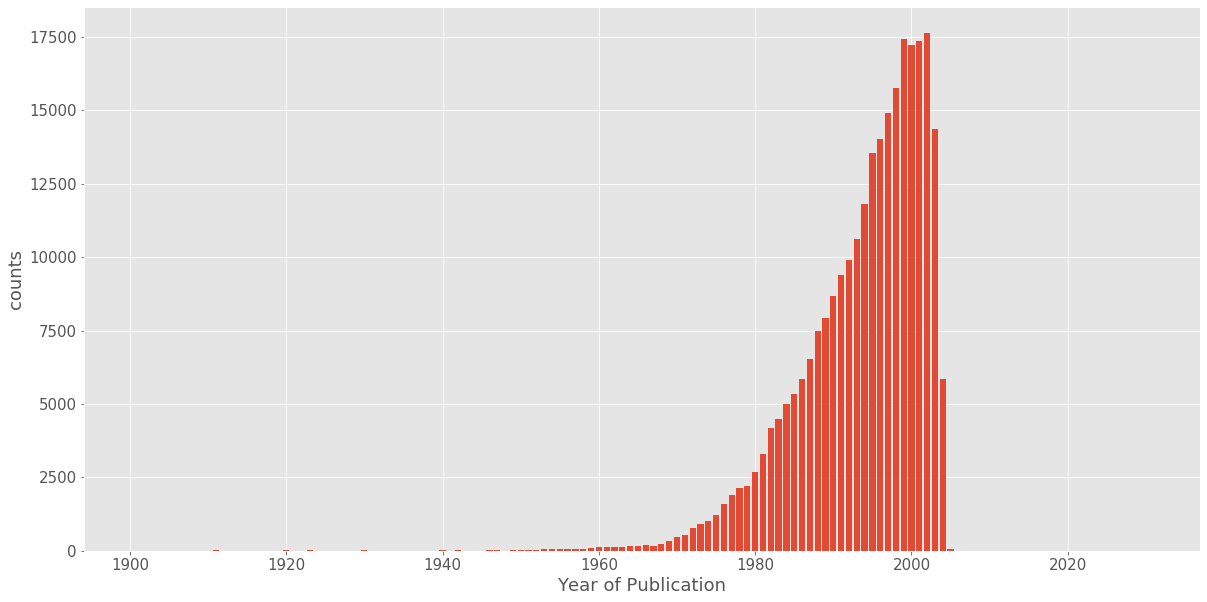

In [26]:
yr = books.year_of_publication.value_counts().sort_index()
yr = yr.where(yr>5) # filter out counts less than 5
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(yr.index, yr.values)
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.show()

Note that in the plot above we filtered out counts less than 5, as there are a few books in the dataset with publication years in the 1300s, and a few in the future (?!). The plot above show the general trend that more recent books are much more frequent.

Let's take a look at some of those 'outlier' books.

In [27]:
historical_books = books[books.year_of_publication<1900] # create df of old books
books_from_the_future = books[books.year_of_publication>2019] # create df of books with publication yrs in the future!

hist_books_mini = historical_books[['book_title', 'year_of_publication']]
future_books_mini = books_from_the_future[['book_title', 'year_of_publication']]
print(f'Historical books:\n{hist_books_mini}')
print('\n')
print(f'Future books:\n{future_books_mini}')

Historical books:
                                               book_title  year_of_publication
171817  Complete Works 10 Volumes [2,6,7,8,9] (Notable...               1806.0
227531                   Dalan-i bihisht (Dastan-i Irani)               1378.0
245607  Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...               1897.0
253750                                       Tasht-i khun               1376.0


Future books:
                                               book_title  year_of_publication
30010                                          The Royals               2020.0
37487   MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...               2030.0
55676   MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...               2030.0
78168                                    Crossing America               2030.0
80264   Alice's Adventures in Wonderland and Through t...               2050.0
92156                     Edgar Allen Poe Collected Poems               2020.0
97826       Outlin

I think we can probably omit the 'historical_books' as they may potentially skew the model and do not seem to have much relevance to the wider userbase.

Some of the 'future' books actually appear to be errors (e.g. Alice in Wonderland, Edgar Allen Poe, etc.)... Perhaps they were supposed to be e.g. 1950 instead of 2050? However, instead of investigating this further, since there are <20 books here I will simply remove them from the 'books' table.

In [28]:
print(f'Length of books dataset before removal: {len(books)}')
books = books.loc[~(books.isbn.isin(historical_books.isbn))] # remove historical books
books = books.loc[~(books.isbn.isin(books_from_the_future.isbn))] # remove historical books
print(f'Length of books dataset after removal: {len(books)}')

Length of books dataset before removal: 271360
Length of books dataset after removal: 271339


We clean up the ampersand formatting in the Publisher field.

In [29]:
books.publisher = books.publisher.str.replace('&amp', '&', regex=False)
books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &; Company


Check that there are no duplicated book entries.

In [30]:
uniq_books = books.isbn.nunique()
all_books = books.isbn.count()
print(f'No. of unique books: {uniq_books} | All book entries: {all_books}')

No. of unique books: 271339 | All book entries: 271339


Let's look at the most frequent Publishing houses in the dataset.

In [31]:
top_publishers = books.publisher.value_counts()[:10]
print(f'The 10 publishers with the most entries in the books table are:\n{top_publishers}')

The 10 publishers with the most entries in the books table are:
Harlequin                   7535
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3646
Scholastic                  3159
Simon &; Schuster           2969
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: publisher, dtype: int64


What about authors with the most entries?

In [32]:
top_authors = books.book_author.value_counts()[:10]
print(f'The 10 authors with the most entries in the books table are:\n{top_authors}')

The 10 authors with the most entries in the books table are:
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: book_author, dtype: int64


We should search for empty or NaN values in these fields too.

In [33]:
empty_string_publisher = books[books.publisher == ''].publisher.count()
nan_publisher = books.publisher.isnull().sum()
print(f'There are {empty_string_publisher} entries with empty strings, and {nan_publisher} NaN entries in the Publisher field')

There are 0 entries with empty strings, and 2 NaN entries in the Publisher field


Great - no empty strings in the Publisher field, and only 2 NaNs.

In [34]:
empty_string_author = books[books.book_author == ''].book_author.count()
nan_author = books.book_author.isnull().sum()
print(f'There are {empty_string_author} entries with empty strings, and {nan_author} NaN entries in the Author field')

There are 0 entries with empty strings, and 1 NaN entries in the Author field


Cool, only 1 NaN in the Author field.

Let's look at the titles.

In [35]:
top_titles = books.book_title.value_counts()[:10]
print(f'The 10 book titles with the most entries in the books table are:\n{top_titles}')

The 10 book titles with the most entries in the books table are:
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
Dracula                           20
Adventures of Huckleberry Finn    20
The Secret Garden                 20
Jane Eyre                         19
The Night Before Christmas        18
Pride and Prejudice               18
Great Expectations                17
Name: book_title, dtype: int64


This is actually quite an important observation. Although all of the ISBN entries are unique in the 'books' dataframe, different forms of the same book will have different ISBNs - i.e. paperback, e-book, etc. Therefore, we can see that some books have multiple ISBN entries (e.g. Jane Eyre has 19 different ISBNs, each corresponding to a different version of the book).

Let's take a look at, for example, the entries for 'Jane Eyre'.

In [36]:
books[books.book_title=='Jane Eyre']

,isbn,book_title,book_author,year_of_publication,publisher
3323,0451518845,Jane Eyre,Charlotte Bronte,1999.0,New Amer Library Classics
9545,0451523326,Jane Eyre,Charlotte Bronte,1988.0,Signet Classics
27657,1566193028,Jane Eyre,Charlotte Bronte,1994.0,Dorset Press
28501,156619024X,Jane Eyre,Charlotte Bronte,NaN,Barnes Noble Classics
40050,8426102069,Jane Eyre,Charlotte Bronte,1997.0,Juventud
41265,0553210203,Jane Eyre,Charlotte Bronte,1981.0,Bantam Books
58243,0460012878,Jane Eyre,Charlotte Bronte,1976.0,J m Dent &; Sons Ltd
69689,0141305371,Jane Eyre,Charlotte Bronte,1999.0,Puffin Books
72306,2253004359,Jane Eyre,Charlotte BrontÃ?Â«,1991.0,LGF
84642,0812523377,Jane Eyre,Charlotte Bronte,1994.0,Tor Books


It looks like each ISBN assigned to the book 'Jane Eyre' has different Publisher and Year of Publication values also.

It might be more useful for our model if we simplified this to give each book a unique identifier, independent of the book format, as our recommendations will be for a book, not a specific version of a book. Therefore, all values in the Jane Eyre example above would stay the same, except all of the Jane Eyre entries would additionally be assigned a unique ISBN code as a new field.


#### 3. Investigate Ratings Data

I will first tidy up the column names (replacing '-' caracter with '_').

In [37]:
# replacing '-' caracter with '_'
book_ratings.columns = book_ratings.columns.str.strip().str.lower().str.replace('-', '_')
book_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
user_id        1149780 non-null int64
isbn           1149780 non-null object
book_rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [38]:
book_ratings.dtypes

user_id         int64
isbn           object
book_rating     int64
dtype: object

The data types already look good. Remember that the ISBN numbers may contain letters, and so should be left as strings.

Which users contribute the most ratings?

In [39]:
active_users = book_ratings.groupby('user_id').isbn.count().sort_values(ascending=False)
print(f'The 20 users with the most ratings:\n{active_users[:20]}')

The 20 users with the most ratings:
user_id
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
230522     2991
16795      2948
234623     2674
36836      2529
52584      2512
245963     2507
204864     2504
55492      2459
185233     2448
171118     2421
Name: isbn, dtype: int64


Wow! User #11676 has almost twice as many ratings as the next highest user!

Let's see how they are distributed.

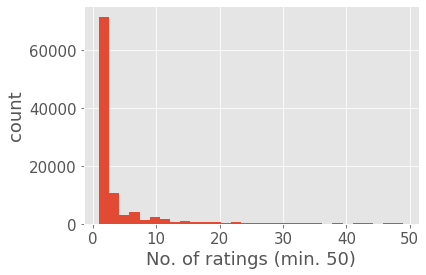

In [40]:
# user distribution - users with less than 50 ratings removed
user_hist = active_users.where(active_users<50)
user_hist.hist(bins=30)
plt.xlabel('No. of ratings (min. 50)')
plt.ylabel('count')
plt.show()

It looks like by far the most frequent events are users with only 1 or 2 rating entries. We can see that the 'super users' with thousands of ratings are significant outliers.

This becomes clear if we make the same histogram with a cutoff for users with a minimum of 1000 ratings.

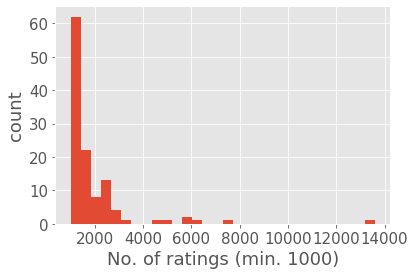

In [41]:
# only users with more than 1000 ratings
active_user_hist = active_users.where(active_users>1000)
active_user_hist.hist(bins=30)
plt.xlabel('No. of ratings (min. 1000)')
plt.ylabel('count')
plt.show()

Let's see what the distribution of ratings looks like.

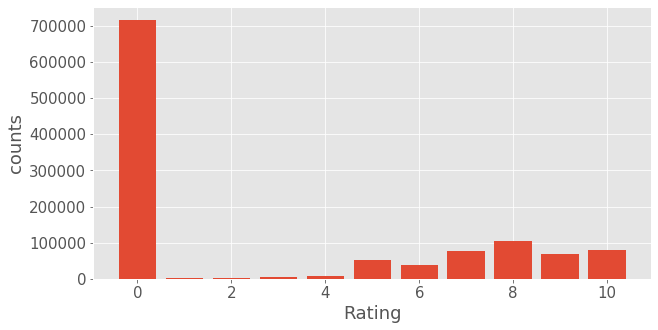

In [42]:
rtg = book_ratings.book_rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

Seems like most of the entries have a rating of zero!

The explicit ratings represented by 1–10 and implicit ratings represented by 0 will have to be segregated now. We will be using only explicit ratings for building our book recommendation system

For the modeling step we'll only be looking at explicit ratings, and so the 0 rating entry rows will be removed.

In [43]:
print(f'Size of book_ratings before removing zero ratings: {len(book_ratings)}')
book_ratings = book_ratings[book_ratings.book_rating != 0]
print(f'Size of book_ratings after removing zero ratings: {len(book_ratings)}')

Size of book_ratings before removing zero ratings: 1149780
Size of book_ratings after removing zero ratings: 433671


By removing the implicit ratings we have reduced our sample size by more than half.

Let's look at how the ratings are distributed again.

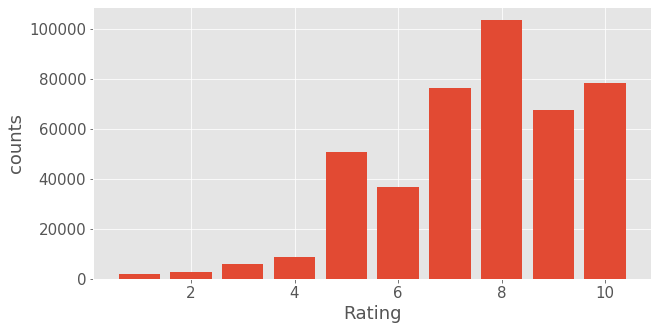

In [44]:
rtg = book_ratings.book_rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

This is much more clear! Now we can see that 8 is the most frequent rating, while users tend to give ratings > 5, with very few low ratings given.

#### 4. Unify dataset (users,books,ratings)

##### unify books and ratings

In [45]:
print(f'Books table size: {len(books)}')
print(f'Ratings table size: {len(book_ratings)}')
books_with_ratings = book_ratings.join(books.set_index('isbn'), on='isbn')
print(f'New table size: {len(books_with_ratings)}')

Books table size: 271339
Ratings table size: 433671
New table size: 433671


##### investigate new dataset

In [46]:
books_with_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 7 columns):
user_id                433671 non-null int64
isbn                   433671 non-null object
book_rating            433671 non-null int64
book_title             383810 non-null object
book_author            383809 non-null object
year_of_publication    378026 non-null float64
publisher              383808 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 26.5+ MB


In [47]:
print(f'There are {books_with_ratings.book_title.isnull().sum()} books with no title/author information.')
print(f'This represents {(books_with_ratings.book_title.isnull().sum()/len(books_with_ratings)*100):.2f}% of the ratings dataset.')

There are 49861 books with no title/author information.
This represents 11.50% of the ratings dataset.


There seems to be quite a few ISBNs in the ratings table that did not match an ISBN in the books table, almost 9% of all entries!

There isn't really anything we can do about that, but we should really remove them from the dataset as we won't be able to access the title of the book to make a recommendation even if the model can use them.

It looks like the year_of_publication field contains the most NaN entries, while user_id, isbn, and book_rating are full. The book_title, book_author, and publisher fields contain approximately the same number of missing entries.

We'll choose to remove rows for which the book_title is empty, as this is the most crucial piece of data needed to identify the book.

In [48]:
books_with_ratings.dropna(subset=['book_title'], inplace=True) # remove rows with missing title/author data

##### books haveing the highest cumulative book rating values.

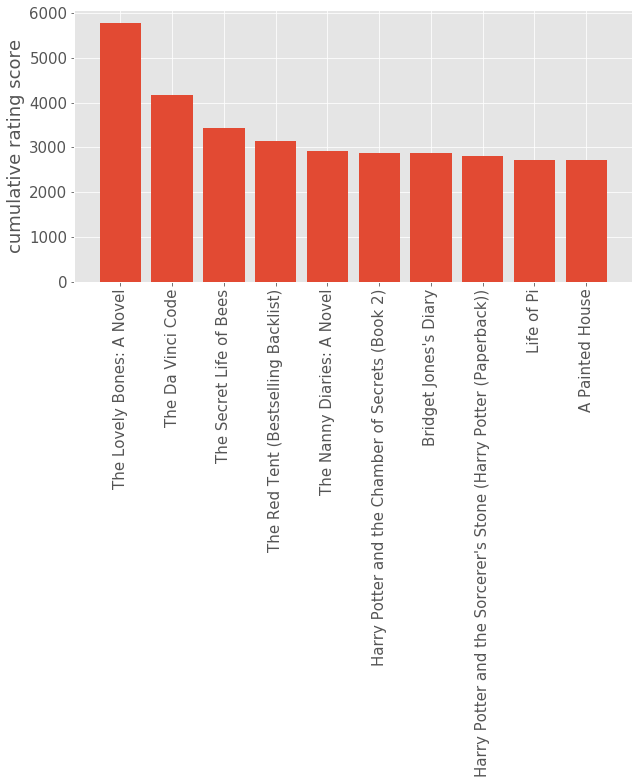

In [49]:
cm_rtg = books_with_ratings.groupby('book_title').book_rating.sum()
cm_rtg = cm_rtg.sort_values(ascending=False)[:10]
idx = cm_rtg.index.tolist() # Get sorted book titles
vals = cm_rtg.values.tolist() # Get corresponding cm_rtg values

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.bar(range(len(idx)), vals)
plt.xticks(range(len(idx)), idx, rotation='vertical')
plt.ylabel('cumulative rating score')
plt.show()

This seems about right as it combines the total number of ratings with the score given, so these are all really popular book titles.

What about the highest average ratings (with a minimum of at least 50 ratings recieved)?

In [50]:
cutoff = books_with_ratings.book_title.value_counts()
mean_rtg = books_with_ratings[books_with_ratings.book_title.isin(cutoff[cutoff>50].index)].groupby('book_title')['book_rating'].mean()
mean_rtg.sort_values(ascending=False)[:10] # show only top 10

book_title
The Two Towers (The Lord of the Rings, Part 2)            9.330882
The Return of the King (The Lord of the Rings, Part 3)    9.213592
Harry Potter and the Goblet of Fire (Book 4)              9.125506
The Little Prince                                         9.111111
Charlotte's Web (Trophy Newbery)                          9.073529
Harry Potter and the Sorcerer's Stone (Book 1)            9.062500
84 Charing Cross Road                                     9.049180
Harry Potter and the Order of the Phoenix (Book 5)        9.047393
Harry Potter and the Prisoner of Azkaban (Book 3)         9.043321
To Kill a Mockingbird                                     8.977528
Name: book_rating, dtype: float64

This looks perfectly reasonable. The Harry Potter and Lord of the Rings books rate extremely highly, as expected.

How about the lowest-rated books?

In [51]:
mean_rtg.sort_values(ascending=False)[-10:] # bottom 10 only

book_title
Slow Waltz in Cedar Bend                                  6.619718
My Gal Sunday                                             6.607843
Hornet's Nest                                             6.591398
Bleachers                                                 6.583333
Full Tilt (Janet Evanovich's Full Series)                 6.568627
Songs in Ordinary Time (Oprah's Book Club (Paperback))    6.530303
4 Blondes                                                 5.653846
Isle of Dogs                                              5.433962
Four Blondes                                              5.393939
Wild Animus                                               4.390706
Name: book_rating, dtype: float64

Seems like the lowest average rating in the dataset is only a 4.39 - and all the rest of the books have average ratings higher than 5.

I haven't heard of any of these books, so I can't really comment on if they seem correct here.

**Now I'd like to tackle the challenge of the same book potentially having multiple ISBN numbers (for the different formats it is available in). We should clean that up here before we add the 'user' table.**

##### Restrict books to a "single ISBN per book" (regardless of format)

Let's look again at the book titles which have the most associated ISBN numbers.

In [52]:
books_with_ratings.groupby('book_title').isbn.nunique().sort_values(ascending=False)[:10]

book_title
The Secret Garden                 18
Selected Poems                    16
Adventures of Huckleberry Finn    15
Dracula                           15
Beloved                           14
Wuthering Heights                 14
Jane Eyre                         14
Pride and Prejudice               14
Little Women                      14
The Hobbit                        12
Name: isbn, dtype: int64

In [53]:
multiple_isbns = books_with_ratings.groupby('book_title').isbn.nunique()
multiple_isbns.value_counts()

1     125322
2       7872
3       1497
4        493
5        181
6         86
7         44
8         27
9         11
10         8
14         5
15         2
11         2
18         1
16         1
12         1
Name: isbn, dtype: int64

We can see that the vast majority of books have less only 1 associated ISBN number, however quite a few multiple ISBNs. We want to create a ```unique_isbn``` such that a single book will only have 1 identifier when fed to the recommendation model.

In [54]:
has_mult_isbns = multiple_isbns.where(multiple_isbns>1)
has_mult_isbns.dropna(inplace=True) # remove NaNs, which in this case is books with a single ISBN number

In [55]:
print(f'There are {len(has_mult_isbns)} book titles with multiple ISBN numbers which we will try to re-assign to a unique identifier')

There are 10231 book titles with multiple ISBN numbers which we will try to re-assign to a unique identifier


In [56]:
# Check to see that our friend Jane Eyre still has multiple ISBN values
has_mult_isbns['Jane Eyre']

14.0

**Note:** Created the dictionary below and pickled it, just need to load it again (or run it if the first time on a new system).

In [57]:
# Create dictionary for books with multiple isbns
# def make_isbn_dict(df):
#     title_isbn_dict = {}
#     for title in has_mult_isbns.index:
#         isbn_series = df.loc[df.book_title==title].isbn.unique() # returns only the unique ISBNs
#         title_isbn_dict[title] = isbn_series.tolist()
#     return title_isbn_dict

# %time dict_unique_isbn = make_isbn_dict(books_with_ratings)

In [58]:
# As the loop takes a while to run (8 min on the full dataset), pickle this dict for future use
# with open('multiple_isbn_dict.pickle', 'wb') as handle:
#     pickle.dump(dict_unique_isbn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
# LOAD isbn_dict back into namespace
with open('multiple_isbn_dict.pickle', 'rb') as handle:
    multiple_isbn_dict = pickle.load(handle)

In [60]:
print(f'There are now {len(multiple_isbn_dict)} books in the ISBN dictionary that have multiple ISBN numbers')

There are now 10231 books in the ISBN dictionary that have multiple ISBN numbers


Let's take a quick look in the dict we just created for the 'Jane Eyre' entry - it should contain a list of 14 ISBN numbers.

In [61]:
print(f'Length of Jane Eyre dict entry: {len(multiple_isbn_dict["Jane Eyre"])}\n')
multiple_isbn_dict['Jane Eyre']

Length of Jane Eyre dict entry: 14



['1590071212',
 '0451518845',
 '0451523326',
 '843761449X',
 '156619024X',
 '8426102069',
 '1566193028',
 '0141305371',
 '3548301231',
 '0812523377',
 '0517668432',
 '2253004359',
 '0553210203',
 '0451515560']

Looking good!

As I don't really know what each of the different ISBN numbers refers to (from what I understand the code actually signifies various things including publisher, year, type of print, etc, but decoding this is outside the scope of this analysis), I'll just select the **first** ISBN number that appears in the list of values to set as our ```unique_isbn``` for that particular book.

_**Note**_: ISBN numbers are currently 13 digits long, but used to be 10. Any ISBN that isn't 10 or 13 digits long is probably an error that should be handled somehow. Any that are 9 digits long might actually be SBN numbers (pre-1970), and can be converted into ISBN's by just pre-fixing with a zero.

In [62]:
# Add 'unique_isbn' column to 'books_with_ratings' dataframe that includes the first ISBN if multiple ISBNS,
# or just the ISBN if only 1 ISBN present anyway.
def add_unique_isbn_col(df):
    df['unique_isbn'] = df.apply(lambda row: multiple_isbn_dict[row.book_title][0] if row.book_title in multiple_isbn_dict.keys() else row.isbn, axis=1)
    return df

%time books_with_ratings = add_unique_isbn_col(books_with_ratings)

Wall time: 8.13 s


In [63]:
books_with_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383810 entries, 1 to 1149778
Data columns (total 8 columns):
user_id                383810 non-null int64
isbn                   383810 non-null object
book_rating            383810 non-null int64
book_title             383810 non-null object
book_author            383809 non-null object
year_of_publication    378026 non-null float64
publisher              383808 non-null object
unique_isbn            383810 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 26.4+ MB


The table now includes our ```unique_isbn``` field.

Let's check to see if the 'Jane Eyre' entries have been assigned the ISBN '1590071212', which was the first val in the dictionary for this title.

In [64]:
books_with_ratings[books_with_ratings.book_title=='Jane Eyre'].head()

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,unique_isbn
10481,387,1590071212,9,Jane Eyre,Charlotte Bronte,2002.0,New Millenium Audio,1590071212
16178,2718,0451518845,10,Jane Eyre,Charlotte Bronte,1999.0,New Amer Library Classics,1590071212
35499,8370,0451523326,8,Jane Eyre,Charlotte Bronte,1988.0,Signet Classics,1590071212
50842,11676,0451523326,9,Jane Eyre,Charlotte Bronte,1988.0,Signet Classics,1590071212
58066,11676,843761449X,8,Jane Eyre,Charlotte Bronte,1998.0,Ediciones Catedra S.A.,1590071212


Great! Seems to have worked well.

We won't replace the original ISBN column with the 'unique_isbn' column, but just note that the recommendation model should be based on the 'unique_isbn' field.

##### unify users with books_with_ ratings on the 'user_id' field

In [65]:
print(f'Books+Ratings table size: {len(books_with_ratings)}')
print(f'Users table size: {len(users)}')
books_users_ratings = books_with_ratings.join(users.set_index('user_id'), on='user_id')
print(f'New "books_users_ratings" table size: {len(books_users_ratings)}')

Books+Ratings table size: 383810
Users table size: 278858
New "books_users_ratings" table size: 383810


##### Inspect the new table.

In [80]:
books_users_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383810 entries, 1 to 1149778
Data columns (total 12 columns):
user_id                383810 non-null int64
isbn                   383810 non-null object
book_rating            383810 non-null int64
book_title             383810 non-null object
book_author            383809 non-null object
year_of_publication    378026 non-null float64
publisher              383808 non-null object
unique_isbn            383810 non-null object
age                    267996 non-null float64
city                   383810 non-null object
state                  383810 non-null object
country                373330 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 38.1+ MB


There are a few missing ```age```, ```year_of_publication```, ```publisher```, and ```country``` entries, but the primary fields of ```user_id```, ```unique_isbn```, and ```book_rating``` are all full, which is good.

In terms of the data types, ```user_id``` and ```book_rating``` are integers, while the ```unique_isbn``` are strings (which is expected as the ISBN numbers may also contain letters).

In [81]:
books_users_ratings.shape

(383810, 12)

There are 383,810 entries in this dataset, with 12 fields/columns.

Finally, I will create a new dataframe that contains only the relevant columns (```user_id```, ```unique_isbn```, and ```book_rating```).

In [82]:
user_item_rating = books_users_ratings[['user_id', 'unique_isbn', 'book_rating']]
user_item_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383810 entries, 1 to 1149778
Data columns (total 3 columns):
user_id        383810 non-null int64
unique_isbn    383810 non-null object
book_rating    383810 non-null int64
dtypes: int64(2), object(1)
memory usage: 11.7+ MB


#### Data Filteration
There are two reasons why we want to filter to roughly 13,500 movies in our dataset.

 - Memory issue: we don't want to run into the “MemoryError” during model training Improve 
 - KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [84]:
## To ensure statistical significance, users with less than 20 ratings, and books with less than 20 ratings are excluded.
popularity_thres = 100
popular_users = user_item_rating['user_id'].value_counts()
user_item_rating = user_item_rating[user_item_rating['user_id'].isin(popular_users[popular_users >= popularity_thres].index)]
popular_books = user_item_rating['book_rating'].value_counts()
user_item_rating = user_item_rating[user_item_rating['book_rating'].isin(popular_books[popular_books >= popularity_thres].index)]
user_item_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103266 entries, 1456 to 1147615
Data columns (total 3 columns):
user_id        103266 non-null int64
unique_isbn    103266 non-null int64
book_rating    103266 non-null int64
dtypes: int64(3)
memory usage: 3.2 MB


In [85]:
num_users = len(user_item_rating.user_id.unique())
num_items = len(user_item_rating.unique_isbn.unique())
print('There are {} unique users and {} unique books in this data set'.format(num_users, num_items))

There are 449 unique users and 61644 unique books in this data set


In [86]:
user_maxId = user_item_rating.user_id.max()
item_maxId = user_item_rating.unique_isbn.max()
print('There are {} distinct users and the max of user ID is also {}'.format(num_users, user_maxId))
print('There are {} distinct books, however, the max of book ID is {}'.format(num_items, item_maxId))
print('In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space')
print('So we need to do some data cleaning to reduce the dimension of item vector back to {}'.format(num_items))

There are 449 distinct users and the max of user ID is also 278418
There are 61644 distinct books, however, the max of book ID is 9997555635
In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space
So we need to do some data cleaning to reduce the dimension of item vector back to 61644


In [87]:
def reduce_item_dim(user_item_rating):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, user_item_rating should have columns ['user_id', 'unique_isbn', 'book_rating']
    output: pd.DataFrame, user_item_rating with new 'isbn' that is compressed
    """
    # pivot
    df_user_item = user_item_rating.pivot_table(index='user_id', columns='unique_isbn', values='book_rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('user_id') \
        .melt(
            id_vars='user_id', 
            value_vars=df_user_item.columns,
            var_name='unique_isbn',
            value_name='book_rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['user_id', 'unique_isbn']).reset_index(drop=True)

In [88]:
print('reduce item dimension before:')
user_item_rating.shape

reduce item dimension before:


(103266, 3)

In [89]:
user_item_rating = reduce_item_dim(user_item_rating)
print('reduce item dimension after:')
user_item_rating.shape

reduce item dimension after:


(102492, 3)

## 2. Split Data Into Train/Test

In [90]:
df_train, df_test = train_test_split(user_item_rating, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(81993, 3)
shape of test data set:
(20499, 3)


## 3. Train Generalized Matrix Factorization and Test Model

### define GMF model architeture and train routine

In [91]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_items: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath='data/tmp/model.hdf5',
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

### create GMF model

In [92]:
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        4500        user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        616450      item_input[0][0]                 
____________________________________________________________________________________________

### train GMF model

In [93]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.user_id.values, df_train.unique_isbn.values],
                      outputs=df_train.book_rating.values)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).